In [1]:
import numpy as np

def bit_interleave(*args):
    """Interleave bits from multiple coordinates to generate a Hilbert index."""
    n = len(args)
    max_bits = max(arg.bit_length() for arg in args)
    result = 0
    for i in range(max_bits):
        for j in range(n):
            if args[j] & (1 << i):
                result |= (1 << (i * n + j))
    return result

def bit_deinterleave(index, dims, bits):
    """Extract coordinate values from a Hilbert index."""
    coords = [0] * dims
    for i in range(bits):
        for j in range(dims):
            if index & (1 << (i * dims + j)):
                coords[j] |= (1 << i)
    return coords

def hilbert_index_to_coordinates(index, dims, order):
    """Convert a Hilbert index into n-dimensional coordinates."""
    bits = order
    return bit_deinterleave(index, dims, bits)

def coordinates_to_hilbert_index(coords, order):
    """Convert n-dimensional coordinates to a Hilbert index."""
    return bit_interleave(*coords)

# Example Usage
dims = 3  # 3D Hilbert curve
order = 5  # Curve order (higher = finer resolution)
index = 42
coords = hilbert_index_to_coordinates(index, dims, order)
recovered_index = coordinates_to_hilbert_index(coords, order)

print(f"Index {index} maps to coordinates {coords}")
print(f"Coordinates {coords} map back to index {recovered_index}")


Index 42 maps to coordinates [2, 1, 2]
Coordinates [2, 1, 2] map back to index 42


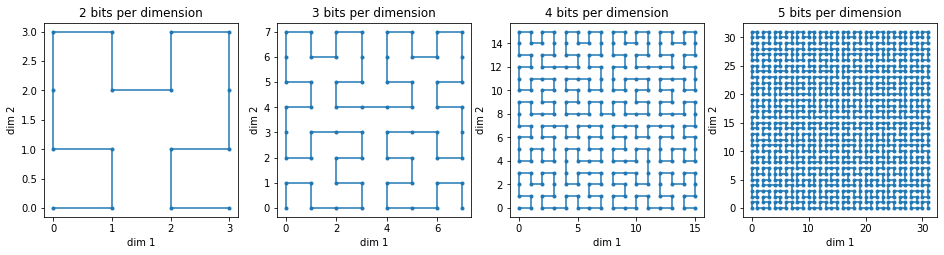

In [6]:
import numpy             as np
import matplotlib.pyplot as plt

from hilbert import decode
from hilbert import encode

num_dims = 2

def draw_curve(ax, num_dims, num_bits):

  # The maximum Hilbert integer.
  max_h = 2**(num_bits*num_dims)

  # Generate a sequence of Hilbert integers.
  hilberts = np.arange(max_h)

  # Compute the 2-dimensional locations.
  locs = decode(hilberts, num_dims, num_bits)

  # Draw
  ax.plot(locs[:,0], locs[:,1], '.-')
  ax.set_aspect('equal')
  ax.set_title('%d bits per dimension' % (num_bits))
  ax.set_xlabel('dim 1')
  ax.set_ylabel('dim 2')


fig = plt.figure(figsize=(16,4))
for ii, num_bits in enumerate([2, 3, 4, 5]):
  ax = fig.add_subplot(1,4,ii+1)
  draw_curve(ax, num_dims, num_bits)

In [7]:
def draw_hilbert_range(ax, range, num_dims, num_bits):
  # Generate a sequence of Hilbert integers.
  hilberts = np.arange(range[0], range[1]+1)

  # Compute the 2-dimensional locations.
  locs = decode(hilberts, num_dims, num_bits)

  # Draw
  ax.plot(locs[:,0], locs[:,1], 'r.-', )

In [19]:
np.arange(0,1)

array([0])

In [88]:
from itertools import product
import matplotlib.pyplot as plt
import numpy             as np


from hilbert import decode
from hilbert import encode




def get_border_coordinates(query):
    dimensions = len(query)
    ranges = [list(range(interval[0], interval[1] + 1)) for interval in query]
    
    border_points = []
    
    for point in product(*ranges):
        for i in range(dimensions):
            if point[i] == query[i][0] or point[i] == query[i][1]:
                border_points.append(list(point))
                break
    
    return np.asarray(border_points)

def get_hilbert_ranges(query, num_dims, num_bits):
    query = np.asarray(query)
    border_coords = get_border_coordinates(query)
    hilbert_indices = np.asarray(sorted(encode(border_coords, num_dims, num_bits)))

    # Check where the border points are not contiguous
    end_indices = np.where(hilbert_indices[1:] != hilbert_indices[:-1] + 1)[0]
    # Special case for point ranges
    point_ranges = np.where(end_indices[1:] == end_indices[:-1] + 1)[0] + 1 
    hilbert_indices_point_ranges = hilbert_indices[end_indices[point_ranges]]
    next_to_point_ranges = hilbert_indices[end_indices[point_ranges] + 1]
    next_to_point_ranges = np.setdiff1d(next_to_point_ranges, hilbert_indices_point_ranges)

    # Remove point ranges
    mask = np.ones(len(end_indices), dtype=bool)
    mask[point_ranges] = False
    end_indices = end_indices[mask]

    # Compute adjecent Hilbert indices
    adjecent_hilbert_indices = hilbert_indices[end_indices] + 1

    # Compute coordinates of adjecent hilbert indices
    adjecent_coords = decode(adjecent_hilbert_indices, num_dims, num_bits)

    # Check if the adjecent coordinates fall within the query
    inside_mask = np.all((adjecent_coords >= query[:, 0]) & (adjecent_coords <= query[:, 1]), axis=1)
    outside_mask = ~inside_mask

    # Keep only the Hilbert indices that the adjecent coordinates fall outside the query
    cut_indices = np.concatenate([[0], end_indices[outside_mask], [len(hilbert_indices) - 1]])
    cut_hilbert_indices = hilbert_indices[cut_indices]

    # Add the point ranges
    cut_hilbert_indices = np.union1d(cut_hilbert_indices, next_to_point_ranges)
    cut_hilbert_indices = np.concatenate([cut_hilbert_indices, np.repeat(hilbert_indices_point_ranges, 2)])
    cut_hilbert_indices = np.sort(cut_hilbert_indices)

    # Build the ranges
    ranges = []
    for i in range(0, len(cut_hilbert_indices) - 1, 2):
        ranges.append((cut_hilbert_indices[i], cut_hilbert_indices[i+1]))
    
    return ranges

In [92]:
ranges

[(np.uint64(2), np.uint64(13))]

In [ ]:
num_dims = 2
num_bits = 3

query = [[1, 6], [0, 3]]

ranges = get_hilbert_ranges(query, num_dims, num_bits)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,4,1)
draw_curve(ax, num_dims, num_bits)
for r in ranges:
    draw_hilbert_range(ax, r, num_dims, num_bits)

In [11]:
from itertools import product

query = [(0, 2), (0, 2)]

min_corner = [b[0] for b in query]
max_corner = [b[1] for b in query]
corners = list(product(*[[min_corner[d], max_corner[d]] for d in range(dims)]))
np.asarray(corners)

array([[0, 0],
       [0, 2],
       [2, 0],
       [2, 2]])

In [12]:
encode(np.asarray(corners), num_dims, num_bits)

array([ 0, 14,  4,  8], dtype=uint64)

In [13]:
sorted(encode(np.asarray(corners), num_dims, num_bits))

[np.uint64(0), np.uint64(4), np.uint64(8), np.uint64(14)]

In [ ]:
import timeit
import hashlib

